## SimpleITK-test.ipynb

This file is a proof of concept of using SimpleITK to work with the sample data (NRRD and NIfTI formats).

Code is heavily based on the [SimpleITK tutorial notebooks](https://github.com/SimpleITK/TUTORIAL), with some **setup instructions** [here](https://simpleitk.org/TUTORIAL/) (update Anaconda, and download default external image viewer Fiji).

Run in VSCode or Anaconda (`jupyter notebook` command).

TODO: Cite the SimpleITK repo if borrowing their code

Note $_1$: The SimpleITK tutorial is **very** in-depth and covers **a lot** of stuff that I don't think we'll need. The basic stuff here should be most of what we need for this project. The [tutorial repo](https://github.com/SimpleITK/tutorial) has notebooks 0-10. I have not looked closely at notebooks 3-10, but based on their names, I don't think we have a use for them.

Note $_2$: SimpleITK image dimensions are `(x, y, z)`, whereas numpy's are `(z, y, x)`. 😔

In [1]:
import SimpleITK as sitk
import os
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

# These 2 imports are part of the tutorial repo (i.e., can't pip install them)
# If we need these, utilities.py and downloaddata.py exist in the tutorial repo
#import utilities as util
#from downloaddata import fetch_data as fdata

OUTPUT_DIR = "output"
image_viewer = sitk.ImageViewer()

Create an image from scratch

In [2]:
image_3D = sitk.Image(256, 128, 64, sitk.sitkInt16)
image_viewer.Execute(image_3D)

Create image from NRRD file (.nrrd), open in external file viewer (Fiji is the default)

In [3]:
nrrd_reader = sitk.ImageFileReader()
# Pretty sure the ImageFileReader can automatically detect which ImageIO to use so this may not be necessary
nrrd_reader.SetImageIO("NrrdImageIO")

nrrd_reader.SetFileName("../ExampleData/BCP_Dataset_2month_T1w.nrrd")
nrrd_image = nrrd_reader.Execute()

image_viewer.Execute(nrrd_image)

Create image from NIfTI file (.nii.gz or .nii), open in external viewer

In [4]:
nifti_reader = sitk.ImageFileReader()
nifti_reader.SetImageIO("NiftiImageIO")

nifti_reader.SetFileName("../ExampleData/MicroBiome_1month_T1w.nii.gz")
nifti_image = nifti_reader.Execute()

image_viewer.Execute(nifti_image)

MetaImageIO (0x121206600): Unsupported or empty metaData item ITK_FileNotes of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x121206600): Unsupported or empty metaData item aux_file of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x121206600): Unsupported or empty metaData item descrip of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x121206600): Unsupported or empty metaData item intent_name of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x121206600): Unsupported or empty metaData item qto_xyz of type N3itk6MatrixIfLj4ELj4EEEfound, won't be written to image file



Get 2D slice of 3D image using Python slicing, display it inline (not in external viewer)

https://stackoverflow.com/questions/30237024/operate-on-slices-of-3d-image-in-simpleitk-and-create-new-3d-image


dimensions (x, y, z): (195, 233, 159)
pixel ID type: <bound method Image.GetPixelIDTypeAsString of <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x11133fc90> >>


(-0.5, 194.5, 232.5, -0.5)

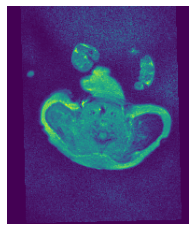

In [5]:
nrrd_reader.SetFileName("../ExampleData/BCP_Dataset_2month_T1w.nrrd")
nrrd_image = nrrd_reader.Execute()

dimensions = nrrd_image.GetSize()
print(f"dimensions (x, y, z): {dimensions}")
print(f"pixel ID type: {nrrd_image.GetPixelIDTypeAsString}")

nrrd_slice = nrrd_image[:, :, 0]

plt.imshow(sitk.GetArrayViewFromImage(nrrd_slice))
plt.axis("off")

Color above looks weird, display in external viewer to make sure it's fine

(Yeah it's fine, but don't know why matplotlib displays color when Fiji displays grayscale)

In [6]:
image_viewer.Execute(nrrd_slice)

Rotate 2D slice of 3D image, display inline for interactivity

[From SimpleITK tutorial 02_images_and_resampling.ipynb](https://github.com/SimpleITK/TUTORIAL/blob/main/02_images_and_resampling.ipynb)

Potential problem: The image dimensions change if the image isn't square.
It'd be pretty janky for the image dimensions to change in the GUI

I believe the original tool handles this problem by displaying a large black border around images (so you can't notice the changed dimensions), but I didn't look at the [recording](https://drive.google.com/drive/u/1/folders/1XuNQJjFJ7oqij2dqYVs22w1mWzEmi8bl) too closely.

Also, don't know what `fixed()` does in this code

In [15]:
def resample_display(image, euler2d_transform, theta):
    euler2d_transform.SetAngle(theta)
    
    resampled_image = sitk.Resample(image, euler2d_transform)
    plt.imshow(sitk.GetArrayFromImage(resampled_image))
    plt.axis("off")
    plt.show()

euler2d = sitk.Euler2DTransform()

#dimensions = nrrd_slice.GetSize()

# Need to set center, otherwise the image will be rotated around the top left corner
euler2d.SetCenter(
    nrrd_slice.TransformContinuousIndexToPhysicalPoint(np.array(nrrd_slice.GetSize()) / 2.0)
)

interact(
    resample_display,
    image=fixed(nrrd_slice),
    euler2d_transform=fixed(euler2d),
    theta=(-np.pi, np.pi)
)

interactive(children=(FloatSlider(value=0.0, description='theta', max=3.141592653589793, min=-3.14159265358979…

<function __main__.resample_display(image, euler2d_transform, theta)>

Do the same test as above but with the NIfTI image

In [16]:
nifti_dimensions = nifti_image.GetSize()
print(f"nifti image dimensions: {nifti_dimensions}")
# This line errors for some reason??? Hard-coding for now
# nifti_slice = nifti_image[:, :, (nifti_dimensions[2]) / 2]
nifti_slice = nifti_image[:, :, 99]


# Create new transform object
# Without this, after running this cell, the center of rotation for the previous image will be wrong
euler2d2 = sitk.Euler2DTransform()

euler2d2.SetCenter(
    nifti_slice.TransformContinuousIndexToPhysicalPoint(np.array(nifti_slice.GetSize()) / 2.0)
)

interact(
    resample_display,
    image=fixed(nifti_slice),
    euler2d_transform=fixed(euler2d2),
    theta=(-np.pi, np.pi)
)


nifti image dimensions: (244, 292, 198)


interactive(children=(FloatSlider(value=0.0, description='theta', max=3.141592653589793, min=-3.14159265358979…

<function __main__.resample_display(image, euler2d_transform, theta)>